# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shriyansh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/shriyansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shriyansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Loading

In [2]:
path = "/Users/shriyansh/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1/News _dataset"

In [3]:
os.listdir(path)

['Fake.csv', 'True.csv']

In [4]:
fake_data = pd.read_csv(os.path.join(path,'Fake.csv'))
true_data = pd.read_csv(os.path.join(path,'True.csv'))

In [5]:
fake_data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [6]:
true_data.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [7]:
fake_data['Label'] = 0
true_data['Label'] = 1

In [8]:
dataset = pd.concat([fake_data, true_data],ignore_index=True)

In [9]:
dataset.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  Label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0

In [10]:
# Shape of all datasets
print("Shape of Dataset merged: ",dataset.shape)
print("Shape of True dataset: ",true_data.shape)
print("Shape of Fake Dataset: ",fake_data.shape)

Shape of Dataset merged:  (44898, 5)
Shape of True dataset:  (21417, 5)
Shape of Fake Dataset:  (23481, 5)


# EDA

## Data Preprocessing

In [11]:
null_values = dataset.isna().sum()
print(null_values)

title      0
text       0
subject    0
date       0
Label      0
dtype: int64


In [12]:
stop_words = set(stopwords.words('english'))
custom_stopwords = set(['said','one','also','would','could','people','say','may','actually','let','include','much','might','put','look','think','time','new','far','way','well','man','according','took','somthing','seem','wasnt'])
all_stopwords = stop_words.union(custom_stopwords)

### Fake and True News Text Extraction

In [13]:
fake_text = " ".join(fake_data['text'].astype(str))
true_text = " ".join(true_data['text'].astype(str))

In [14]:
fake_text = fake_text.lower()
true_text = true_text.lower()

In [15]:
fake_text = [word for word in fake_text.split() if word.isalpha() and word not in all_stopwords]
fake_text= " ".join(fake_text)

In [16]:
true_text = [word for word in true_text.split() if word.isalpha() and word not in all_stopwords]
true_text = " ".join(true_text)

### Fake and True News Title Extraction

In [17]:
fake_title = " ".join(fake_data['title'].astype(str))
true_title = " ".join(true_data['title'].astype(str))

In [18]:
fake_title = fake_title.lower()
true_title = true_title.lower()

In [19]:
fake_title = [word for word in fake_title.split() if word.isalpha() and word not in all_stopwords]
fake_title= " ".join(fake_title)

In [20]:
true_title = [word for word in true_title.split() if word.isalpha() and word not in all_stopwords]
true_title = " ".join(true_title)

# Data visaulization

<div style="font-family: Arial, sans-serif; border-radius: 12px; padding: 22px; background: linear-gradient(90deg, #007bff 0%, #ffffff 50%, #ff9100 100%); box-shadow: 0 2px 16px rgba(0,0,0,0.05);">
  <h3 style="margin-top: 0; color: #1a2233;">🔎 Comparative Word Contribution Analysis: Fake vs. True News</h3>
  <p style="font-size: 1.09em; color: #222; line-height: 1.55;">
    This visualization presents a <strong>comparative analysis of word contributions</strong> within <span style="color: #007bff; font-weight:600;">fake</span> and <span style="color: #ff9100; font-weight:600;">true</span> news articles.
    By highlighting the most influential words for each category, the plot helps us understand <span style="color:#007bff;">which terms are predominantly used in fake news</span> versus those <span style="color:#ff9100;">commonly found in true news</span>.
    <br><br>
    Such insights can aid in identifying key linguistic patterns and improving automated fake news detection systems.
  </p>
</div>


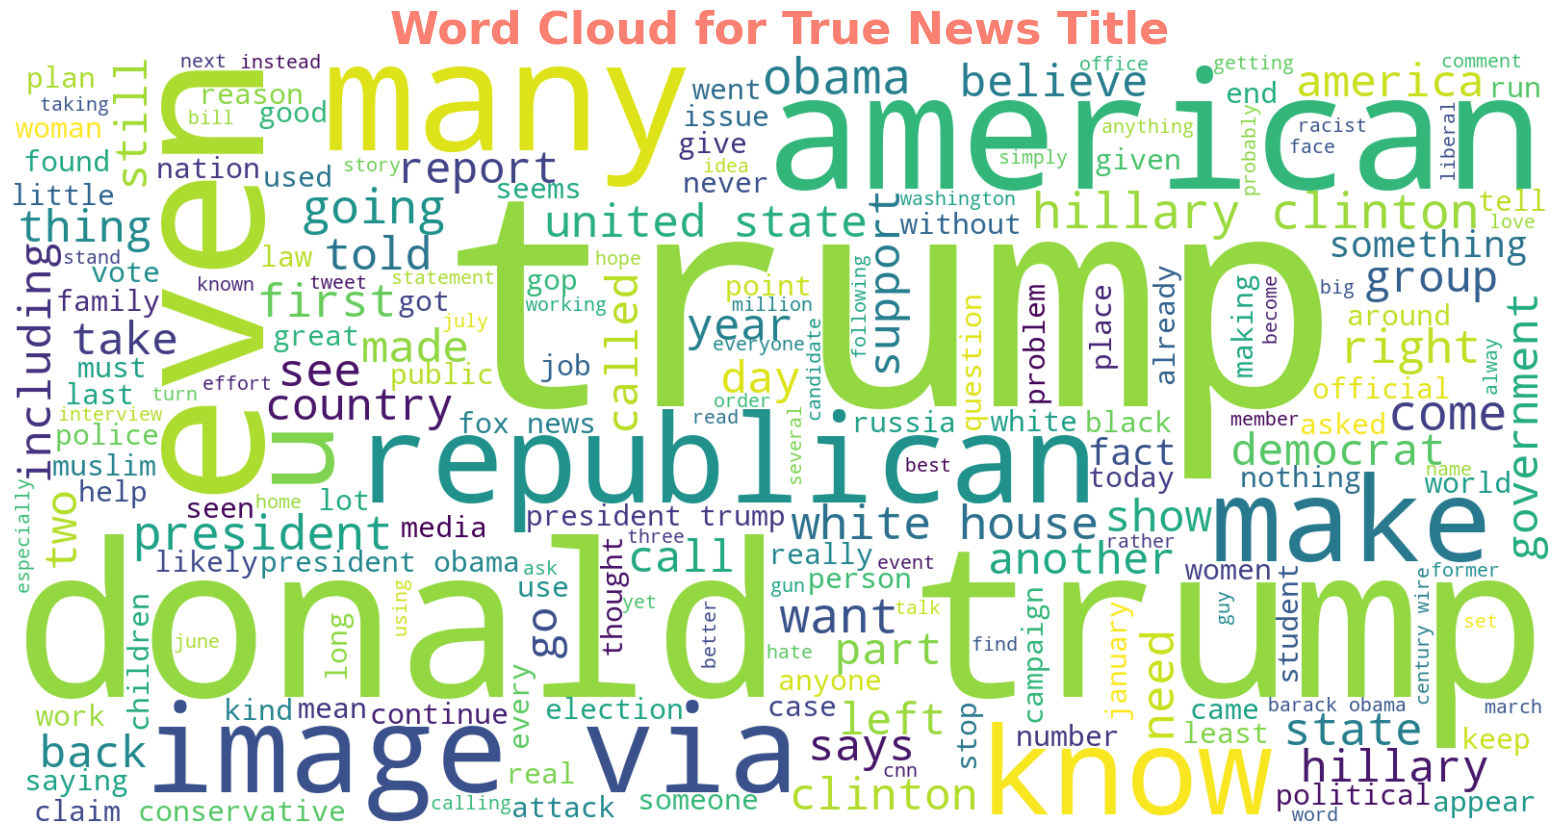

In [21]:
# Create the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(fake_text)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News Title',
          fontsize=32,           
          fontweight='bold',     
          color='salmon')       
plt.show()

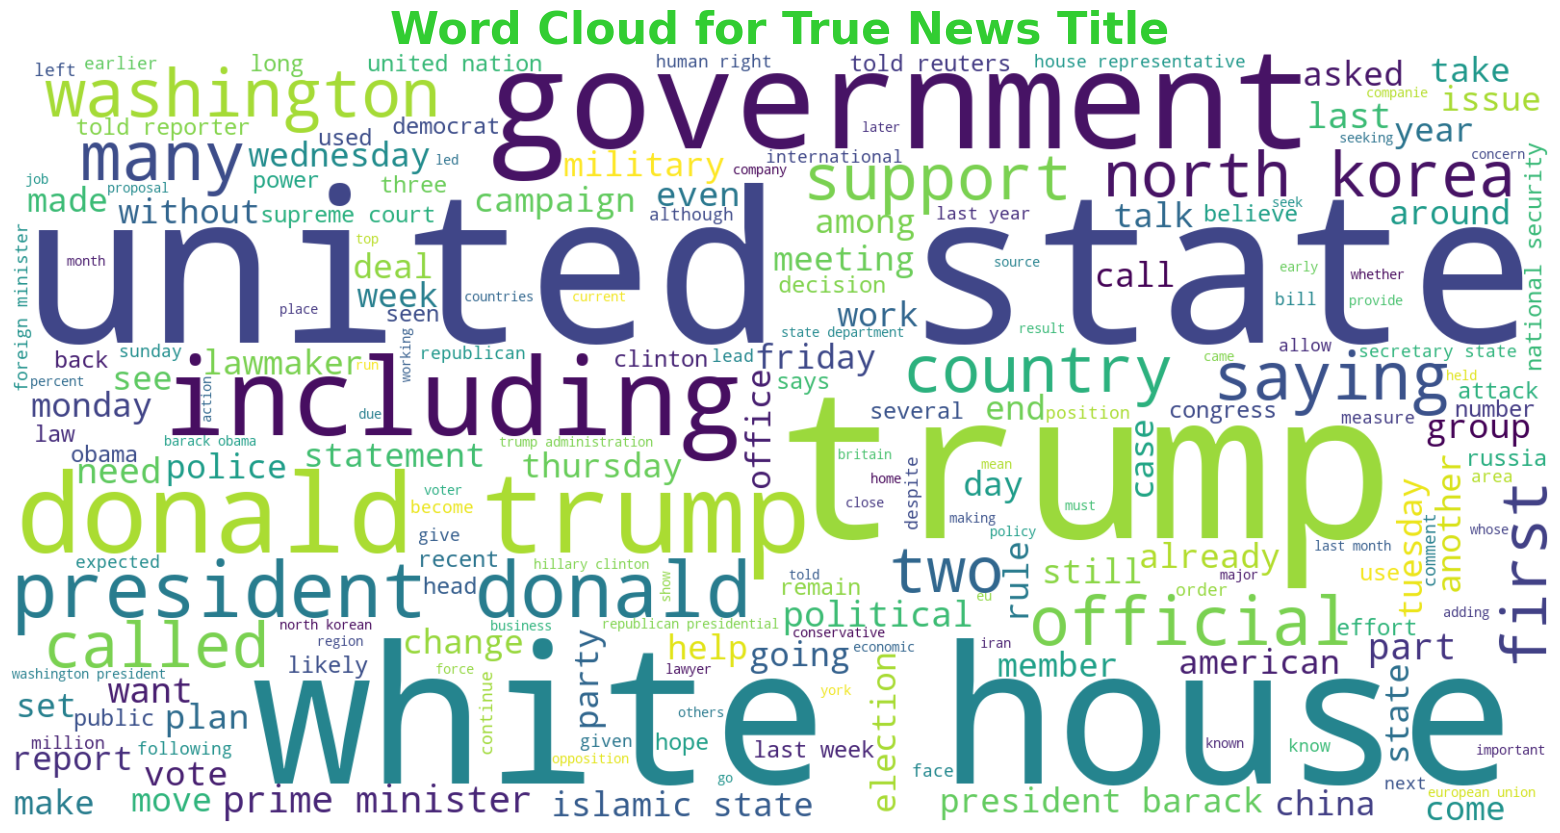

In [22]:
# Create the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(true_text)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News Title',
          fontsize=32,           
          fontweight='bold',     
          color='limegreen')       
plt.show()

<div style="font-family: Arial, sans-serif; border-radius: 14px; padding: 22px; background: linear-gradient(90deg, #b71c1c 0%, #ffeb3b 100%); box-shadow: 0 2px 16px rgba(0,0,0,0.08);">
  <h3 style="margin-top: 0; color: #2a130a;">📰 Key Word Contributions in Fake News Titles</h3>
  <p style="font-size: 1.09em; color: #221a15; line-height: 1.6;">
    This visualization focuses exclusively on the <strong>titles of fake news articles</strong>, highlighting the words that contribute most significantly to their identification.
    <br><br>
    By examining which terms are most influential in fake news headlines, the analysis uncovers important linguistic cues and patterns. These insights can support the development of more effective fake news detection tools and deepen our understanding of <span style="color: #b71c1c; font-weight: 600;">deceptive content</span> in news media.
  </p>
</div>


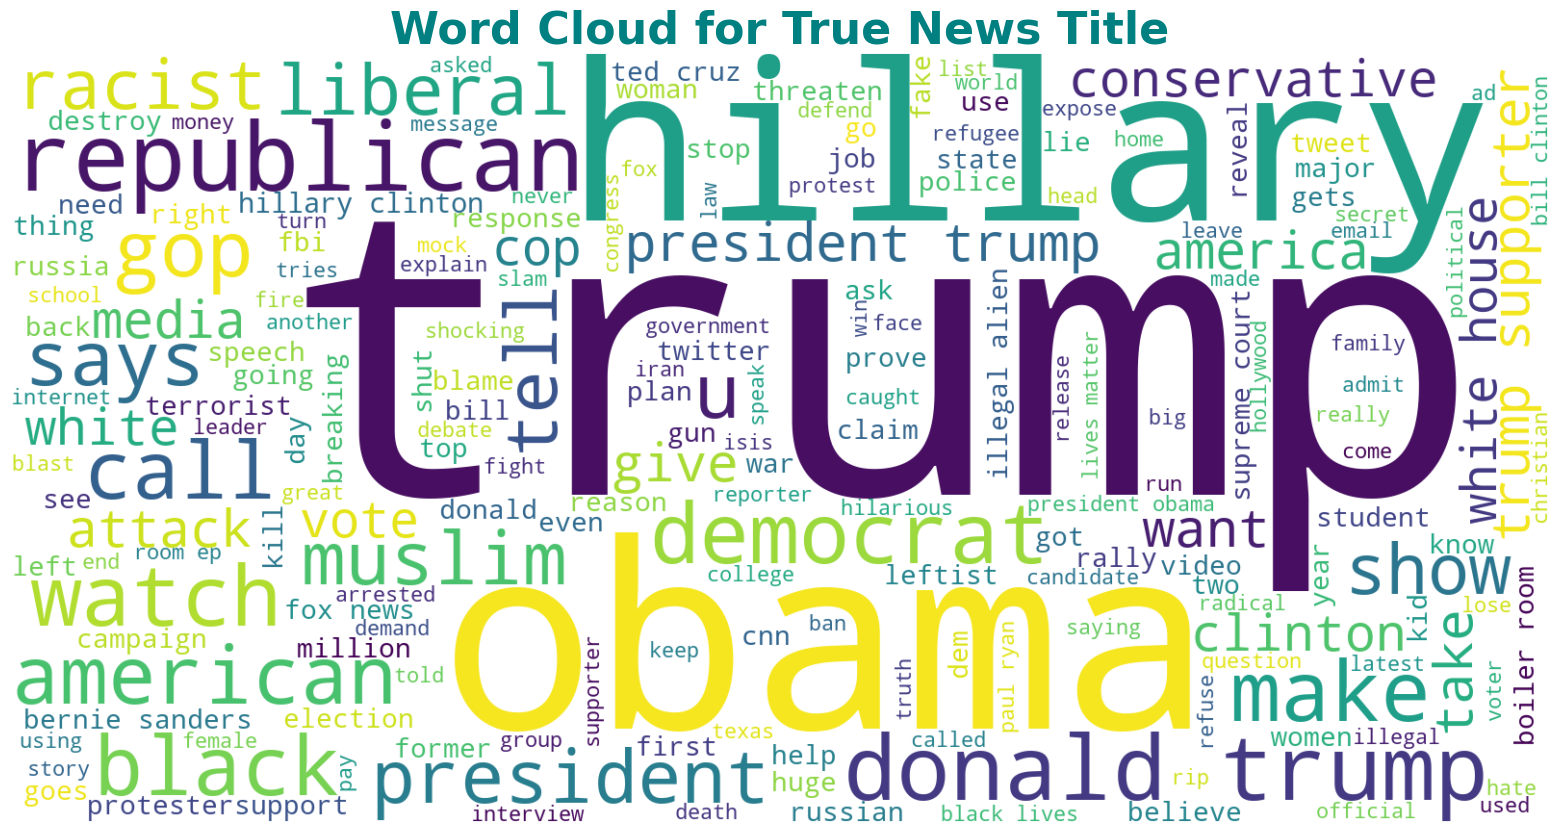

In [23]:
# Create the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(fake_title)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News Title',
          fontsize=32,           
          fontweight='bold',     
          color='teal')       
plt.show()

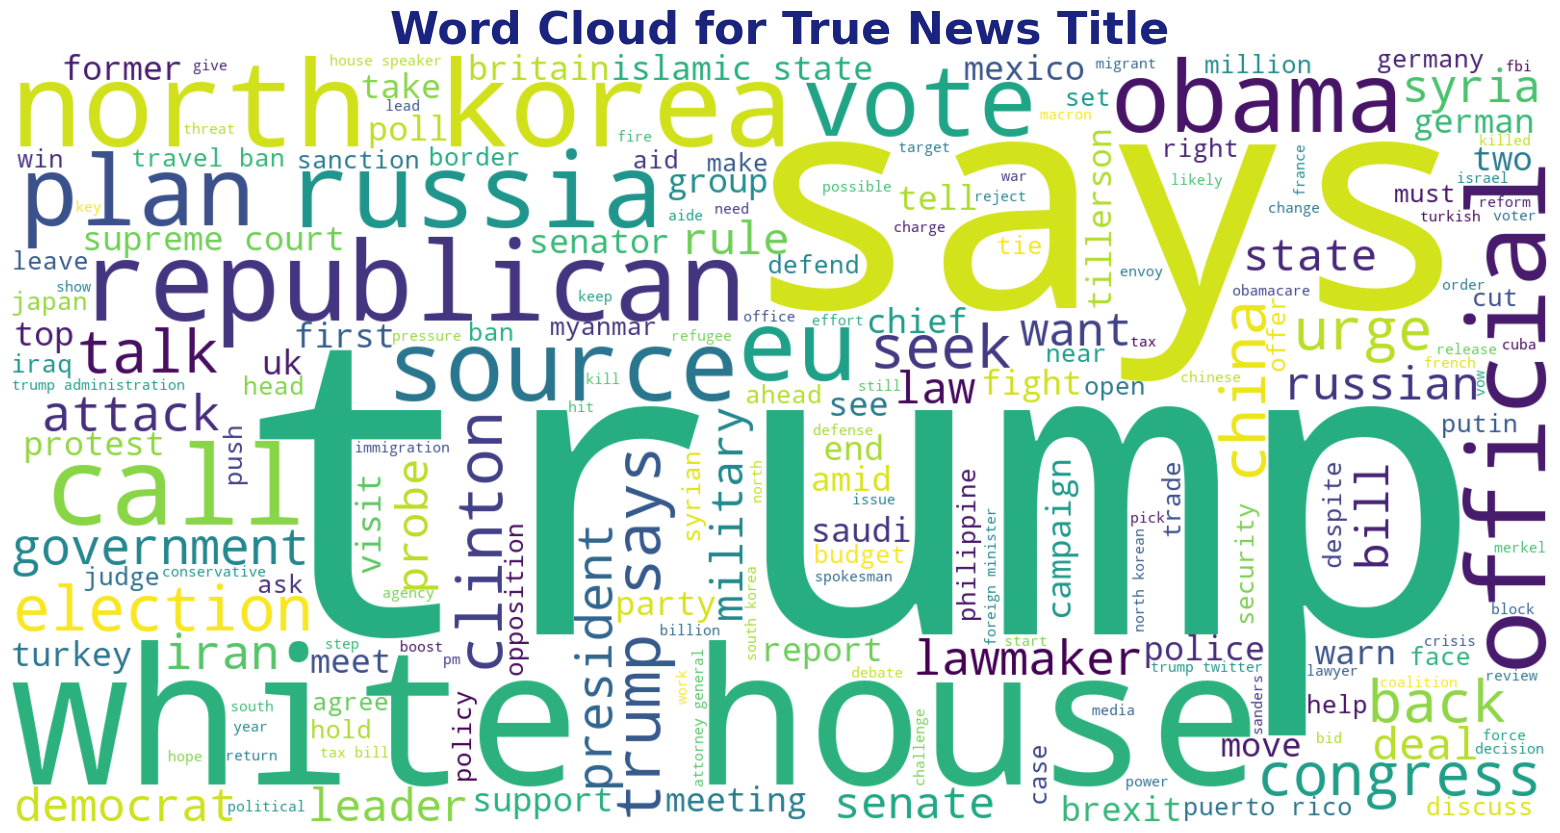

In [24]:
# Create the word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(true_title)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News Title',
          fontsize=32,           
          fontweight='bold',     
          color='#1a237e')       
plt.show()

<div style="font-family: Arial, sans-serif; border-radius: 14px; padding: 22px; background: linear-gradient(90deg, #ffb300 0%, #ffe082 100%); box-shadow: 0 2px 16px rgba(0,0,0,0.09);">
  <h3 style="margin-top: 0; color: #5d3b09;">🔠 Visualization of Top 20 Words in Fake and True News</h3>
  <p style="font-size: 1.09em; color: #5d3b09; line-height: 1.6;">
    This visualization displays the <strong>top 20 words</strong> most frequently used in both fake and true news articles.
    <br><br>
    Identifying these prominent words is critical, as it highlights the linguistic features that are most informative for distinguishing between fake and true news.
    <br><br>
    Such insights are essential for improving the accuracy of automated news classification models and for understanding the vocabulary patterns that characterize authentic and deceptive reporting.
  </p>
</div>


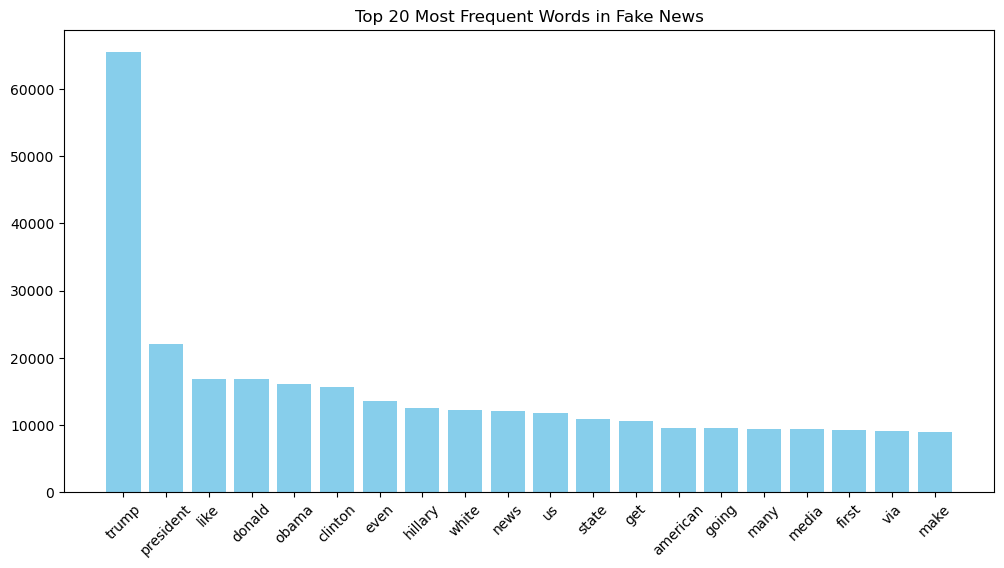

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

# Assuming you have filtered your tokens and removed stopwords
tokens = [word for word in fake_text.split() if word.isalpha() and word not in all_stopwords]
fdist = FreqDist(tokens)
top_words = pd.DataFrame(fdist.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12,6))
plt.bar(top_words['Word'], top_words['Count'], color='skyblue')
plt.title('Top 20 Most Frequent Words in Fake News')
plt.xticks(rotation=45)
plt.show()


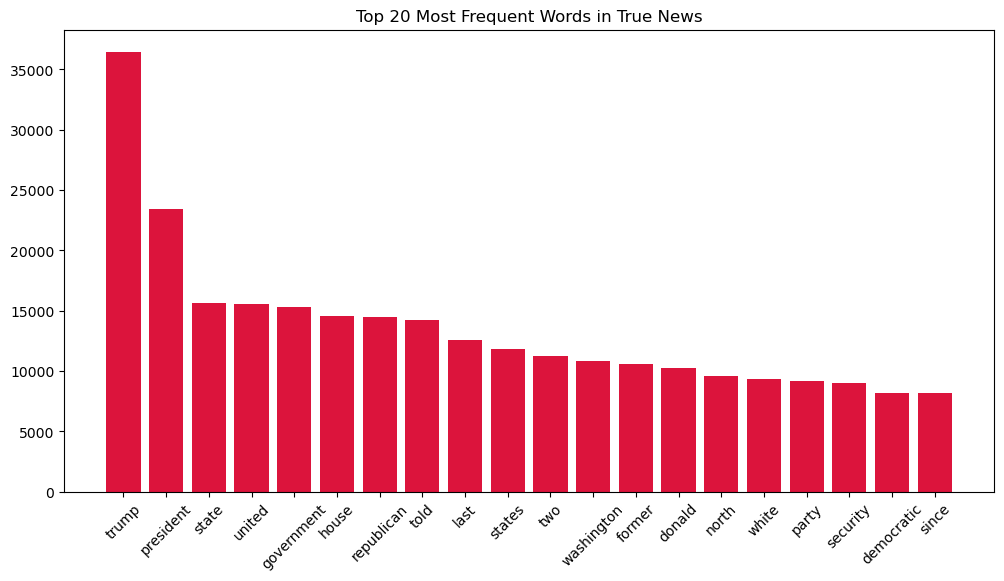

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

# Assuming you have filtered your tokens and removed stopwords
tokens = [word for word in true_text.split() if word.isalpha() and word not in all_stopwords]
fdist = FreqDist(tokens)
top_words = pd.DataFrame(fdist.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12,6))
plt.bar(top_words['Word'], top_words['Count'], color='crimson')
plt.title('Top 20 Most Frequent Words in True News')
plt.xticks(rotation=45)
plt.show()


<div style="font-family: Arial, sans-serif; border-radius: 14px; padding: 22px; background: linear-gradient(90deg, #0f2027 0%, #2c5364 50%, #43cea2 100%); box-shadow: 0 2px 16px rgba(0,0,0,0.10);">
  <h3 style="margin-top: 0; color: #e6f7ff;">📊 Pie Chart Analysis of Fake and True News by Subject</h3>
  <p style="font-size: 1.09em; color: #e6c55a; line-height: 1.65;">
    This pie chart illustrates the <strong>distribution of fake and true news across various subjects</strong>, displaying the percentage share of each category within each subject area.
    <br><br>
    By visualizing this data, we can easily identify <span style="font-weight:600;">which subjects are most frequently associated with fake news</span> and <span style="font-weight:600;">which ones predominantly feature true news</span>.
    <br><br>
    These insights are crucial for effectively targeting misinformation interventions and for understanding the topics most vulnerable to fake news proliferation.
  </p>
</div>


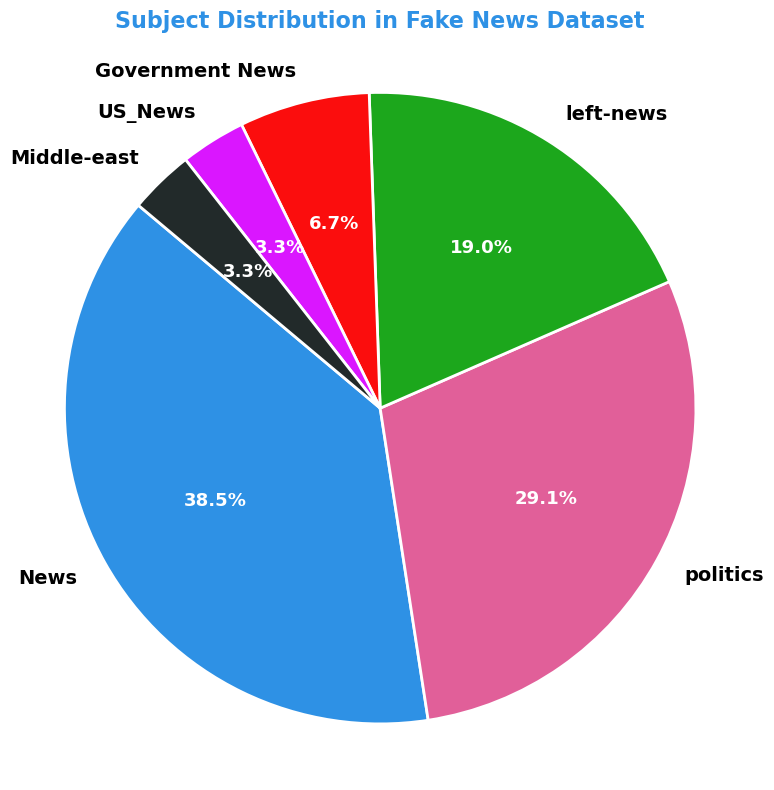

In [27]:
# Count the frequency of each subject
subject_counts = fake_data['subject'].value_counts()

# Define some vibrant colors for your pie chart
colors = [
    "#2E91E5", "#E15F99", "#1CA71C", "#FB0D0D", "#DA16FF",
    "#222A2A", "#B68100", "#750D86"
]

# Create the pie chart
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    subject_counts,
    labels=subject_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 13, 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Make the labels and percentages stand out
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

for text in texts:
    text.set_fontsize(14)
    text.set_fontweight('bold')

# Add a title
plt.title('Subject Distribution in Fake News Dataset', fontsize=16, fontweight='bold', color='#2E91E5')

# Make the pie chart a circle
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()


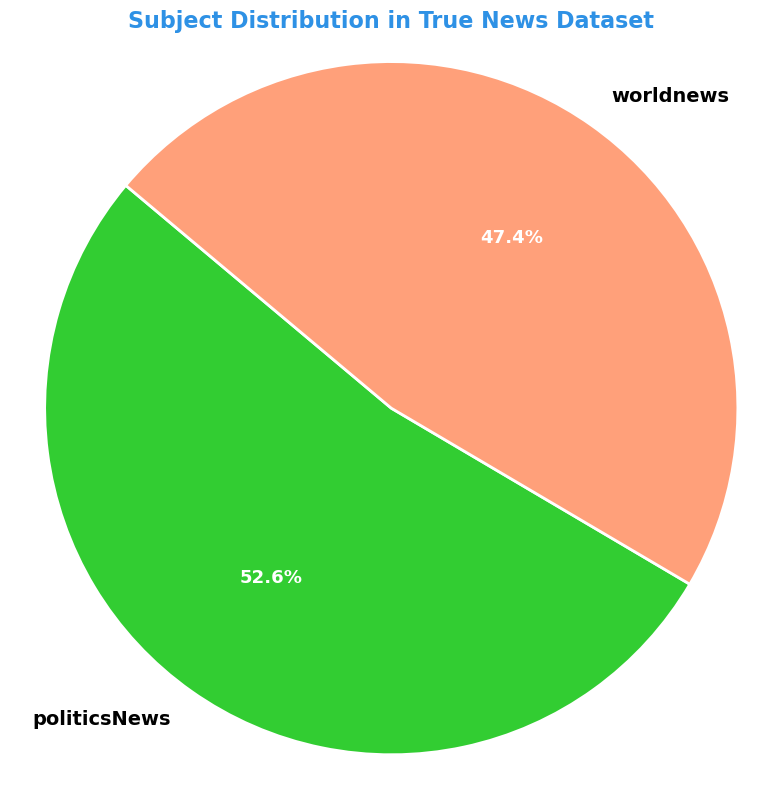

In [28]:
# Count the frequency of each subject
subject_counts = true_data['subject'].value_counts()

# Define some vibrant colors for your pie chart
colors = [
    '#32CD32', '#FFA07A'
]

# Create the pie chart
plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    subject_counts,
    labels=subject_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 13, 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Make the labels and percentages stand out
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

for text in texts:
    text.set_fontsize(14)
    text.set_fontweight('bold')

# Add a title
plt.title('Subject Distribution in True News Dataset', fontsize=16, fontweight='bold', color='#2E91E5')

# Make the pie chart a circle
plt.axis('equal')

# Show the plot
plt.tight_layout()
plt.show()


<div style="font-family: Arial, sans-serif; border-radius: 14px; padding: 22px; background: linear-gradient(90deg, #450006 0%, #7b1122 50%, #a32638 100%); box-shadow: 0 2px 16px rgba(0,0,0,0.13);">
  <h3 style="margin-top: 0; color: #f36b6b;">📈 Monthly Count of Fake vs True News</h3>
  <p style="font-size: 1.09em; color: grey; line-height: 1.65;">
    This chart displays the <strong>monthly count of fake and true news articles</strong>, allowing us to observe how the frequency of each category changes over time.
    <br><br>
    By tracking publication trends, we can identify periods when fake news was most prevalent and compare them to peaks in true news reporting.
    <br><br>
    These insights are valuable for detecting time-based patterns in misinformation and for understanding the temporal dynamics of news dissemination.
  </p>
</div>


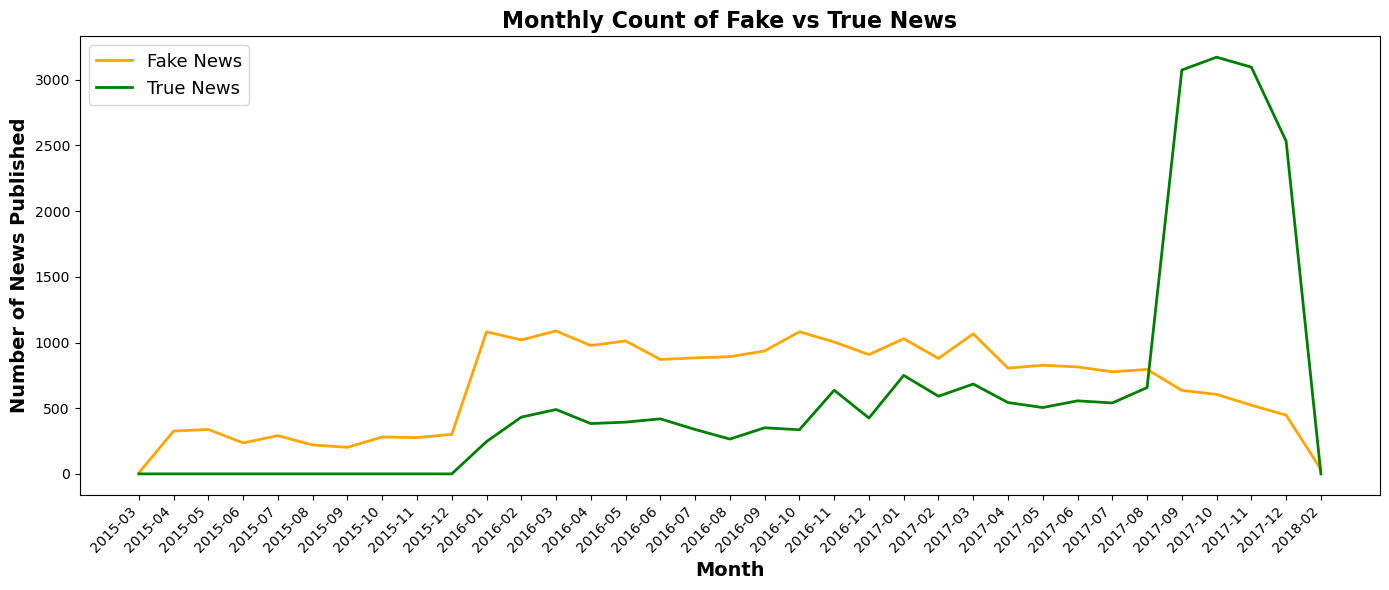

In [29]:
dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce', format='mixed')

# Create a 'month' column (period format for easier grouping)
dataset['month'] = dataset['date'].dt.to_period('M')

# Group by month and label, count occurrences
month_counts = dataset.groupby(['month', 'Label']).size().reset_index(name='count')

# Pivot for plotting
pivot_table = month_counts.pivot(index='month', columns='Label', values='count').fillna(0)

# Convert PeriodIndex back to string for plotting
pivot_table.index = pivot_table.index.astype(str)

# Plot
plt.figure(figsize=(14,6))
plt.plot(pivot_table.index, pivot_table[0], label='Fake News', color='orange', linewidth=2)
plt.plot(pivot_table.index, pivot_table[1], label='True News', color='green', linewidth=2)
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of News Published', fontsize=14, fontweight='bold')
plt.title('Monthly Count of Fake vs True News', fontsize=16, fontweight='bold')
plt.legend(fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing for target variable

In [30]:
dataset['full_text'] = dataset['title']+" "+dataset['text']

In [31]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in all_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [32]:
dataset['cleaned_text'] = dataset['full_text'].apply(clean_text)

In [33]:
dataset['cleaned_text'].iloc[100]

'watch joe biden wrecked trump six word hilarious former vice president joe biden asked monday matt lauer nbc today name something specific donald trump seems like trick question since trump passed major legislation reach across aisle take shot democrat twitter timeline morning biden struggled find something anything trump done since taking office number thing even thing biden tone administration bother continued due respect come thing lauer married biden biden mention trump three marriage speaking trump first marriage ivana ended affair marla maple trump went marry maple divorced trump currently married melania three trump wife former model trump former reality show star instance marry since trump hit struggling come something biden eventually praised trump choice keeping military personnel stationed middle east end obama trump married joe biden answer question todayshow http nbc news nbcnews november january biden advice trump grow donald biden baby grow adult president got ta someth

In [34]:
# finding the maximum lenght
def max_length(text):
    return len(text.split())

dataset['length_text'] = dataset['cleaned_text'].apply(max_length)
dataset['length_text'].max()

4444

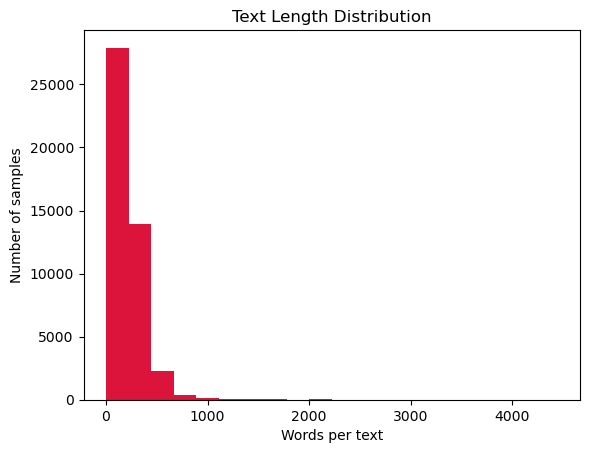

In [35]:
import matplotlib.pyplot as plt
lengths = dataset['cleaned_text'].apply(lambda x: len(x.split()))
plt.hist(lengths, bins=20,color = "crimson")
plt.xlabel("Words per text")
plt.ylabel("Number of samples")
plt.title("Text Length Distribution")
plt.show()

# Data splitting

In [36]:
VOCAB_SIZE = 20000
MAX_LEN = 300

In [37]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(dataset['cleaned_text'])

In [38]:
# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [39]:
y = dataset['Label']
x = padded_sequences

In [40]:
print("Shape of x: ",x.shape)
print("Shape of y:", y.shape)

Shape of x:  (44898, 300)
Shape of y: (44898,)


In [41]:
x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.3, random_state=42)

In [42]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train:  (31428, 300)
Shape of y_train: (31428,)
Shape of x_test:  (13470, 300)
Shape of y_test: (13470,)


# Model Building

In [43]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    This function accepts a list of models, trains, and evaluates each model.
    """

    # List of colors for confusion matrix and ROC curve for each model
    cm_colors = ['Blues', 'Greens', 'Purples', 'Reds', 'Oranges', 'Greys']
    roc_colors = ['blue', 'green', 'purple', 'red', 'orange', 'black']

    for idx, model in enumerate(models):
        model_name = model.__class__.__name__
        print(f"\nEvaluating {model_name}...")

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Model Evaluation
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {model_name}: {accuracy:.4f}")

        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        print(f"Confusion Matrix for {model_name}:")
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap=cm_colors[idx % len(cm_colors)], xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
        plt.title(f"Confusion Matrix - {model_name}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color=roc_colors[idx % len(roc_colors)], lw=2, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.show()

In [296]:
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(),
    XGBClassifier(),
    CatBoostClassifier(),
    LGBMClassifier(),
]


Evaluating LogisticRegression...
Accuracy of LogisticRegression: 0.6189
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      7091
           1       0.60      0.59      0.60      6379

    accuracy                           0.62     13470
   macro avg       0.62      0.62      0.62     13470
weighted avg       0.62      0.62      0.62     13470

Confusion Matrix for LogisticRegression:


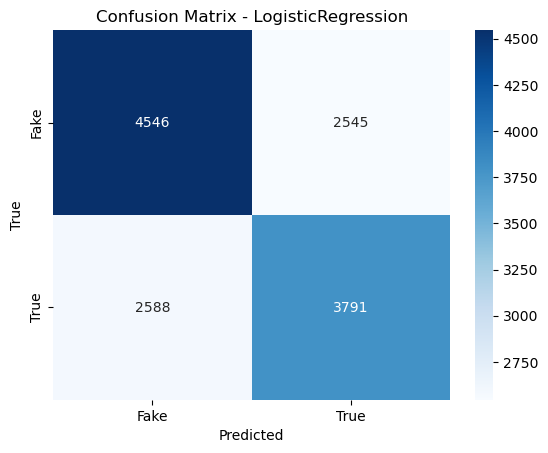

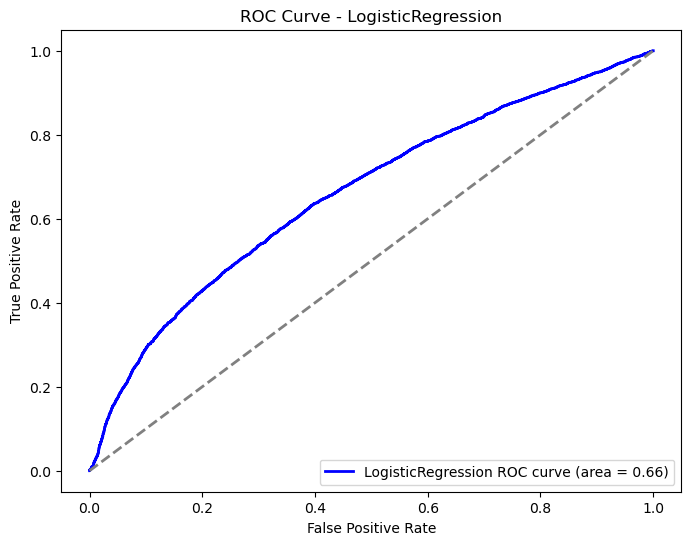


Evaluating RandomForestClassifier...
Accuracy of RandomForestClassifier: 0.8949
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7091
           1       0.89      0.88      0.89      6379

    accuracy                           0.89     13470
   macro avg       0.89      0.89      0.89     13470
weighted avg       0.89      0.89      0.89     13470

Confusion Matrix for RandomForestClassifier:


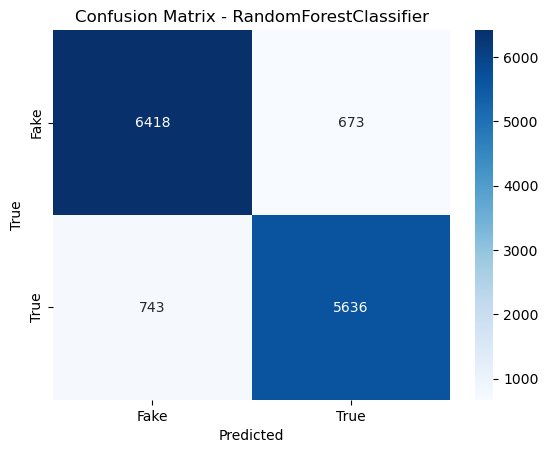

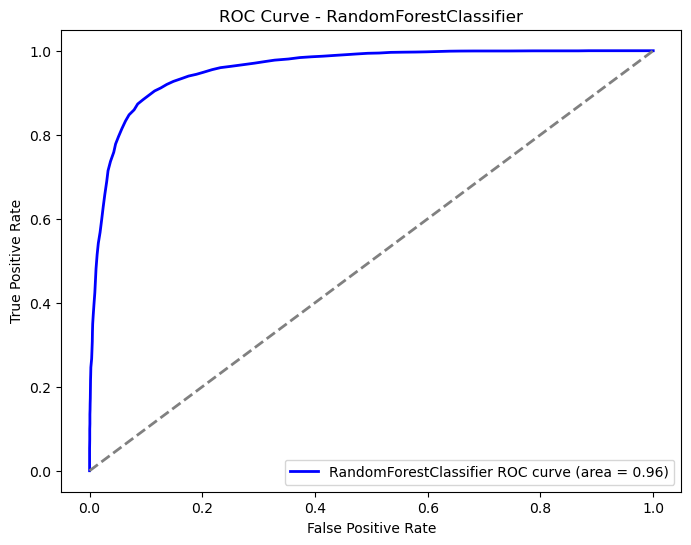


Evaluating SVC...


In [ ]:
evaluate_models(models, x_train, x_test, y_train, y_test)

## Deep Learning RNN Model

In [44]:
def evaluate_dl_model(model, x_test, y_test, history):
    # Plot Accuracy and Loss over epochs
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Predict probabilities and binary outcomes
    y_pred_probs = model.predict(x_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [45]:
lstm_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    LSTM(100),
    Dense(1, activation='sigmoid') 
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = lstm_model.fit(
    x_train, y_train,
    epochs=4,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/4
492/492 ━━━━━━━━━━━━━━━━━━━━ 218s 443ms/step - accuracy: 0.6378 - loss: 0.6211 - val_accuracy: 0.8566 - val_loss: 0.4017
Epoch 2/4
492/492 ━━━━━━━━━━━━━━━━━━━━ 212s 431ms/step - accuracy: 0.8612 - loss: 0.3846 - val_accuracy: 0.8228 - val_loss: 0.4422
Epoch 3/4
492/492 ━━━━━━━━━━━━━━━━━━━━ 228s 464ms/step - accuracy: 0.8359 - loss: 0.3983 - val_accuracy: 0.9203 - val_loss: 0.2481
Epoch 4/4
492/492 ━━━━━━━━━━━━━━━━━━━━ 140s 285ms/step - accuracy: 0.9453 - loss: 0.1862 - val_accuracy: 0.9642 - val_loss: 0.1431


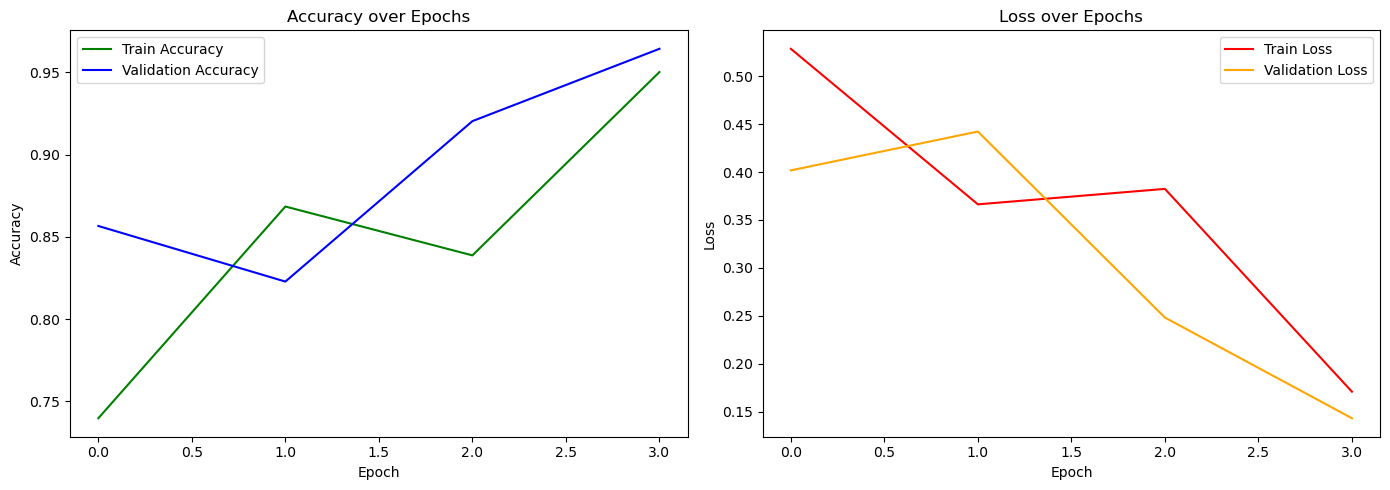

421/421 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.98      0.97      7091
        True       0.97      0.95      0.96      6379

    accuracy                           0.96     13470
   macro avg       0.96      0.96      0.96     13470
weighted avg       0.96      0.96      0.96     13470



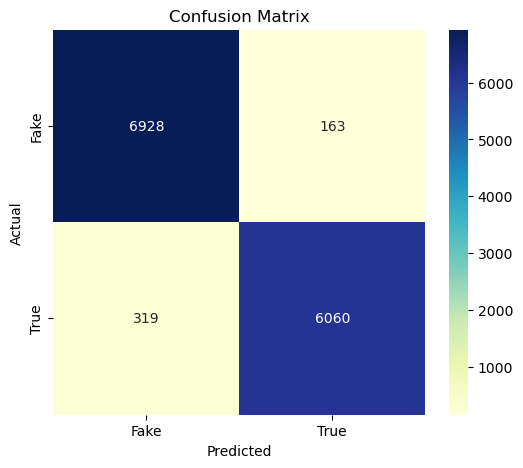

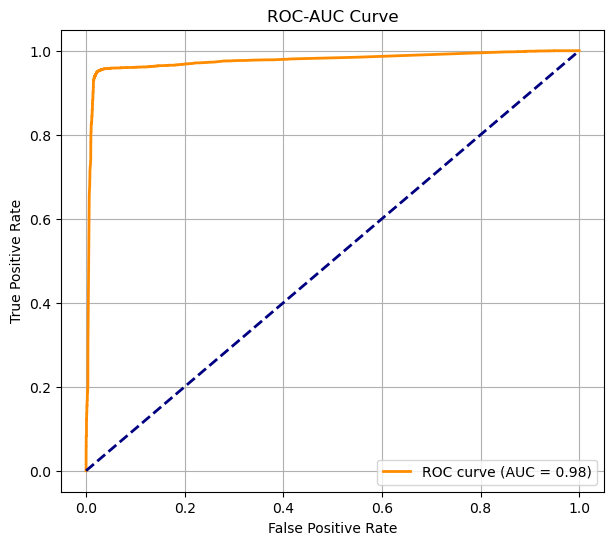

In [47]:
evaluate_dl_model(lstm_model, x_test, y_test, history)

# Bidirectional LSTM

In [53]:
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=40, input_length=MAX_LEN),
    Bidirectional(LSTM(100)),
    Dense(1, activation='sigmoid') 
])

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(
    x_train, y_train,
    epochs=1,
    batch_size=64,
    validation_data=(x_test, y_test)
)

492/492 ━━━━━━━━━━━━━━━━━━━━ 192s 388ms/step - accuracy: 0.8971 - loss: 0.2039 - val_accuracy: 0.9988 - val_loss: 0.0063


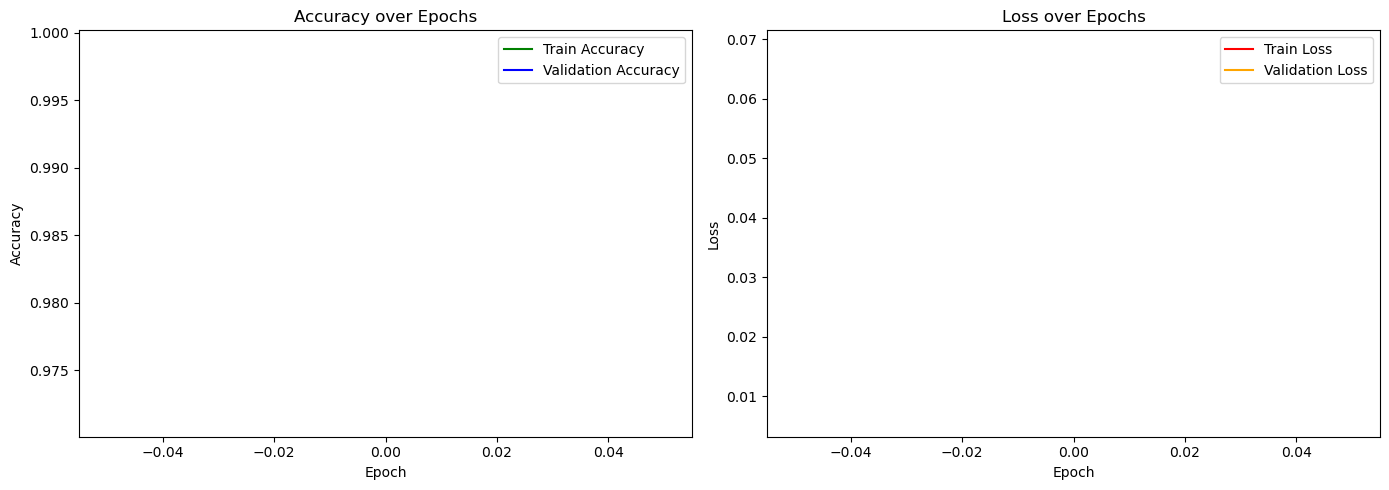

421/421 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step
Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      7091
        True       1.00      1.00      1.00      6379

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470



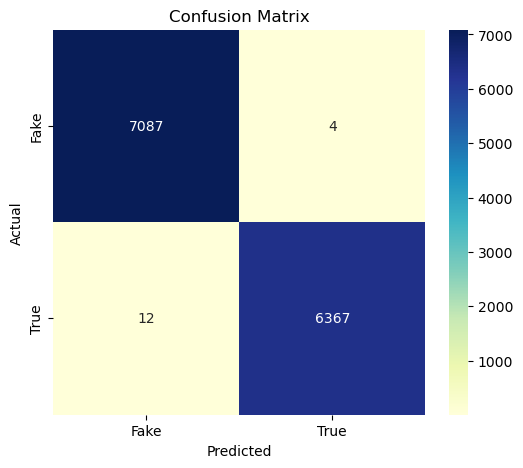

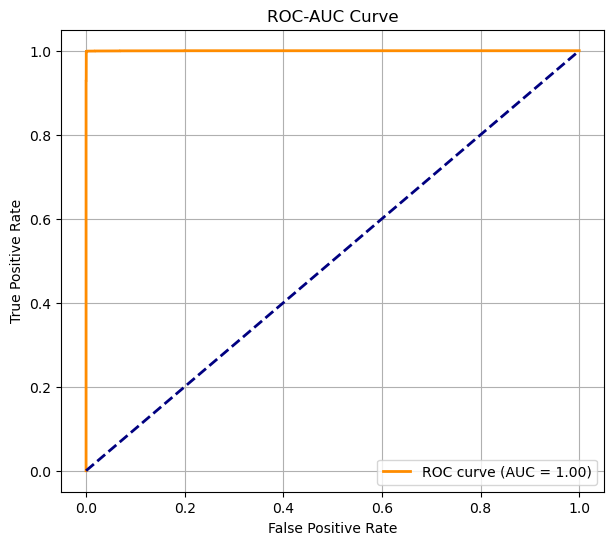

In [55]:
evaluate_dl_model(model, x_test, y_test, history)